In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,confusion_matrix
from sklearn.metrics import plot_roc_curve, roc_auc_score, roc_curve, precision_recall_curve, plot_confusion_matrix
from sklearn.linear_model import SGDClassifier
from collections import Counter
from sklearn import svm
from scipy import stats

import pprint
#plt.style.use('fivethirtyeight') 

# Loading Dataset and Data Cleaning

After your Web Scraping, you should have your dataset ready in the following format.

We will do some basic data cleaning.

In [2]:
df = pd.read_csv('civil_total_df.csv')
df.head()

SteamId                                         ProfileURL  \
0  76561198067125410  https://steamcommunity.com/profiles/7656119806...   
1     tornadochasers      https://steamcommunity.com/id/tornadochasers/   
2         jungle-jim          https://steamcommunity.com/id/jungle-jim/   
3  76561198140433122  https://steamcommunity.com/profiles/7656119814...   
4  76561198253015993  https://steamcommunity.com/profiles/7656119825...   

                                          ReviewText       Review  \
0  I have played Civ right from the start and eve...  Recommended   
1  Great way to time travel, you can start playin...  Recommended   
2  landed on mars as the communist jewish Aztecs ...  Recommended   
3  If you like Civ 5, you'll complain about Civ 6...  Recommended   
4  Very easy to drain a few hours of your life aw...  Recommended   

   ReviewLength(Chars)              PlayHours                DatePosted  \
0                  111  1,208.0 hrs on record         Posted: January 4   
1                   85    699.8 hrs on record        Posted: January 15   
2                   44     35.9 hrs on record   Posted: October 9, 2020   
3                  103    298.6 hrs on record  Posted: October 19, 2020   
4                   70    210.4 hrs on record      Posted: May 12, 2020   

   Award                                          HelpFunny  
0    158  830 people found this review helpful\n46 peopl...  
1     16  299 people found this review helpful\n288 peop...  
2     48  306 people found this review helpful\n365 peop...  
3     19  317 people found this review helpful\n41 peopl...  
4      0  178 people found this review helpful\n36 peopl...

In [3]:
# Data Cleaning Process
# Helpful Column
Helpful = []
for i in df['HelpFunny']:
    x = i.split()
    if x[0] == 'No':
        Helpful.append(int(0))
    else:
        x = x[0].replace(',','')
        Helpful.append(int(x))

# Funny 
Funny = []
for i in df['HelpFunny']:
    x = i.split('\n')
    try:
        y = x[1].split()
        y = y[0].replace(',','')
        Funny.append(int(y))
    except IndexError:
        Funny.append(int(0))
        
#  Hours Played
Hour = []
for i in df['PlayHours']:
    x = i.split()
    x = x[0].replace(',','')
    Hour.append(float(x))

In [8]:
df['Helpful'] = np.array(Helpful)
df['Funny'] = np.array(Funny)
df['Hour'] = np.array(Hour)

In [9]:
# Convert Recommend / Not Recomment to 1 / 0
df['Recommend'] = pd.Series(np.where(df.Review.values == 'Recommended', 1, 0), df.index)

In [10]:
df.head(2)

SteamId                                         ProfileURL  \
0  76561198067125410  https://steamcommunity.com/profiles/7656119806...   
1     tornadochasers      https://steamcommunity.com/id/tornadochasers/   

                                          ReviewText       Review  \
0  I have played Civ right from the start and eve...  Recommended   
1  Great way to time travel, you can start playin...  Recommended   

   ReviewLength(Chars)              PlayHours          DatePosted  Award  \
0                  111  1,208.0 hrs on record   Posted: January 4    158   
1                   85    699.8 hrs on record  Posted: January 15     16   

                                           HelpFunny  Helpful  Funny    Hour  \
0  830 people found this review helpful\n46 peopl...      830     46  1208.0   
1  299 people found this review helpful\n288 peop...      299    288   699.8   

   Recommend  
0          1  
1          1

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10664 entries, 0 to 10663
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SteamId              10664 non-null  object 
 1   ProfileURL           10664 non-null  object 
 2   ReviewText           10630 non-null  object 
 3   Review               10664 non-null  object 
 4   ReviewLength(Chars)  10664 non-null  int64  
 5   PlayHours            10664 non-null  object 
 6   DatePosted           10664 non-null  object 
 7   Award                10664 non-null  int64  
 8   HelpFunny            10664 non-null  object 
 9   Helpful              10664 non-null  int32  
 10  Funny                10664 non-null  int64  
 11  Hour                 10664 non-null  float64
 12  Recommend            10664 non-null  int32  
dtypes: float64(1), int32(2), int64(3), object(7)
memory usage: 999.9+ KB


In [12]:
# making sure it is pure text
df['ReviewText'] = df['ReviewText'].astype('str') 

# Creating Count Vectorizer

We will simple explore the word count using Count Vectorizer.

In [13]:
# First Count Verctorizer on Pure Text
vectorizer = CountVectorizer(strip_accents='ascii',
                             stop_words='english', 
                             min_df=10, 
                             max_features=20)
text = vectorizer.fit_transform(df['ReviewText'])
word_list = vectorizer.get_feature_names()
count_list = text.toarray().sum(axis=0)

# top 20 words with highest counts
combine = dict(zip(word_list,count_list))
combine

{'ai': 3536,
 'better': 1684,
 'city': 2159,
 'civ': 9234,
 'civilization': 2370,
 'dlc': 1710,
 'don': 1914,
 'fun': 1681,
 'game': 17479,
 'games': 2189,
 'good': 2534,
 'great': 1893,
 'just': 4323,
 'like': 4375,
 'new': 2768,
 'play': 2904,
 'played': 1589,
 'really': 2117,
 'time': 2352,
 'turn': 1581}

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


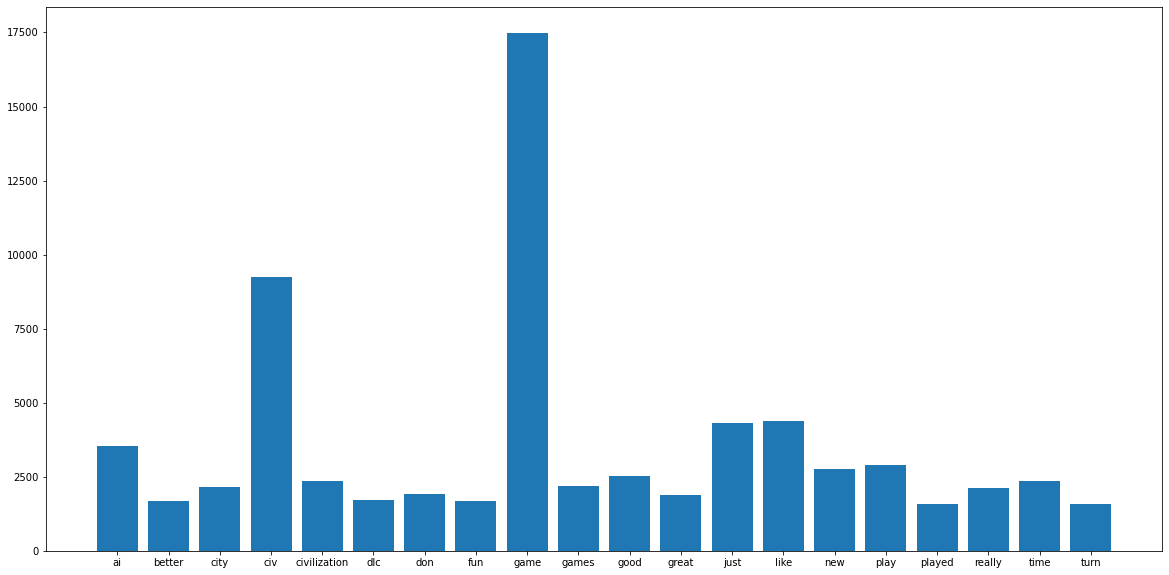

In [14]:
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(range(len(combine)), list(combine.values()), align='center')
ax.set_xticklabels(list(combine.keys()))
ax.set_xticks(range(len(combine)))
plt.show()

In [15]:
# Second Count Verctorizer - 2 Gram
vectorizer2 = CountVectorizer(strip_accents='ascii',
                             stop_words='english', 
                             min_df=10, 
                             max_features=20,
                             ngram_range=(2, 2))

text2 = vectorizer2.fit_transform(df['ReviewText'])
word_list2 = vectorizer2.get_feature_names()
count_list2 = text2.toarray().sum(axis=0)

# top 20 words with highest counts
combine2 = dict(zip(word_list2,count_list2))
combine2

{'base game': 360,
 'city states': 296,
 'civ civ': 252,
 'civ game': 596,
 'civ games': 366,
 'civ vi': 792,
 'civilization vi': 376,
 'feel like': 277,
 'feels like': 276,
 'game civ': 263,
 'game just': 332,
 'game play': 332,
 'good game': 430,
 'great game': 442,
 'late game': 252,
 'like civ': 296,
 'personal information': 308,
 'play game': 324,
 'recommend game': 249,
 've played': 275}

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


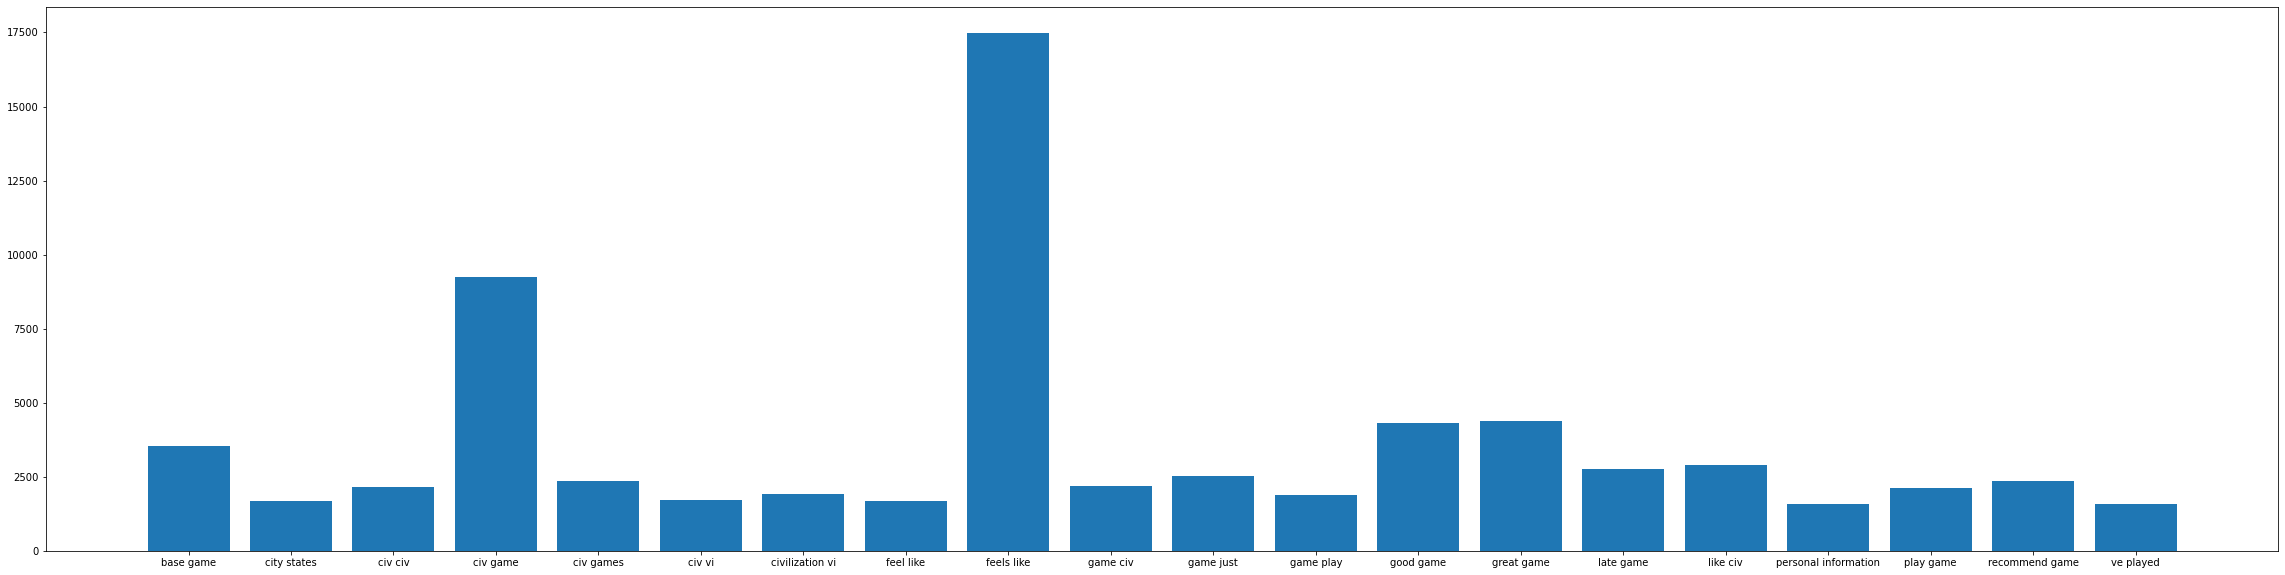

In [16]:
fig, ax = plt.subplots(figsize = (40,10))
ax.bar(range(len(combine)), list(combine.values()), align='center')
ax.set_xticklabels(list(combine2.keys()))
ax.set_xticks(range(len(combine2)))
plt.show()

# NLP Text Cleaning Pipline

We will create an NLP Text Cleaning Pipeline to see which columns provide the best accuracy for our models.

In [17]:
# tokenizer
tokenizer = nltk.tokenize.WhitespaceTokenizer()
def tokenize(review):
    token = [word.lower() for word in tokenizer.tokenize(review)]
    return token

In [18]:
# do some text cleaning pipline
import string
print(string.punctuation)
def remove_punctuation(review):
    no_punct = [word for word in review if word not in string.punctuation]
    return ' '.join(no_punct)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [19]:
# stopwords
my_stopwords = set(['game','games','ha','just','make','civ','civilization',
                    'really','played','playing','play','youtube','good',
                    'great','1010','better','awesome','pretty',
                    'im','like','love','vi','best',"don't",'amazing','bit',
                    'bad','worse','instead','tried','wrost',
                    'ive','say','dont','thing','things','yes','little','fun',
                    "doesnt",'lot','dont','want','definitely','cool','highly'])
nltk_stopwords = nltk.corpus.stopwords.words('english')
# print(nltk_stopwords)

def remove_stopword(review):
    no_stops_words = [word for word in review if word not in nltk_stopwords and word not in my_stopwords]
    return ' ' .join(no_stops_words)

In [20]:
my_stopwords

{'1010',
 'amazing',
 'awesome',
 'bad',
 'best',
 'better',
 'bit',
 'civ',
 'civilization',
 'cool',
 'definitely',
 'doesnt',
 "don't",
 'dont',
 'fun',
 'game',
 'games',
 'good',
 'great',
 'ha',
 'highly',
 'im',
 'instead',
 'ive',
 'just',
 'like',
 'little',
 'lot',
 'love',
 'make',
 'play',
 'played',
 'playing',
 'pretty',
 'really',
 'say',
 'thing',
 'things',
 'tried',
 'vi',
 'want',
 'worse',
 'wrost',
 'yes',
 'youtube'}

In [21]:
# stemming
stemmer = nltk.stem.PorterStemmer()
def stemming_text(review):
    stem = [stemmer.stem(word) for word in review]
    after_stem = ' '.join(stem)
    return after_stem

In [22]:
# lemmatization
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(review):
    lemma = [lemmatizer.lemmatize(word) for word in review]
    after_lemma = ' '.join(lemma)
    return after_lemma

# Create Columns of Text by Applying Each Function

Each reviews now will have different format base on the function you apply. 

Also, text are being cleaned by orders, such as
1. Tokenize
2. Punctuation
3. Stopwords
4. Stemming & Lemmatize

In [23]:
# token
df['Review_Token'] = df['ReviewText'].apply(lambda x: tokenize(x))

In [24]:
# text without punctuation
df['Review_No_Punct'] = df['Review_Token'].apply(lambda x: remove_punctuation(x))
df['Review_No_Punct'] = df['Review_No_Punct'].str.encode('ascii', 'ignore').str.decode('ascii')
df['Review_No_Punct'] = df['Review_No_Punct'].str.replace('[{}]'.format(string.punctuation), '')

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


# Hypothesis Test

Before we continue to apply the function for Stopwords, Stemming and Lemmatization, we can do a simple data exploration and Hypothesis Test.

In [25]:
count_length = 0
count_word = 0 
for i in df['Review_No_Punct']:
    count_length += len(i)
    count_word += len(i.split())
print('average character per review: ' + str(count_length/len(df['Review_No_Punct'])))
print('average word per review: ' + str(count_word/len(df['Review_No_Punct'])))

average character per review: 435.7040510127532
average word per review: 81.58589647411853


In [26]:
df_rcmd = df[df['Review'] == 'Recommended']
df_not_rcmd = df[df['Review'] == 'Not Recommended']

In [28]:
df_rcmd['Character_Length'] = [len(i) for i in df_rcmd['Review_No_Punct']]
df_rcmd['Word_Count'] = [len(i.split()) for i in df_rcmd['Review_No_Punct']]

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
df_not_rcmd['Character_Length'] = [len(i) for i in df_not_rcmd['Review_No_Punct']]
df_not_rcmd['Word_Count'] = [len(i.split()) for i in df_not_rcmd['Review_No_Punct']]

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
df_rcmd.head(2)

SteamId                                         ProfileURL  \
0  76561198067125410  https://steamcommunity.com/profiles/7656119806...   
1     tornadochasers      https://steamcommunity.com/id/tornadochasers/   

                                          ReviewText       Review  \
0  I have played Civ right from the start and eve...  Recommended   
1  Great way to time travel, you can start playin...  Recommended   

   ReviewLength(Chars)              PlayHours          DatePosted  Award  \
0                  111  1,208.0 hrs on record   Posted: January 4    158   
1                   85    699.8 hrs on record  Posted: January 15     16   

                                           HelpFunny  Helpful  Funny    Hour  \
0  830 people found this review helpful\n46 peopl...      830     46  1208.0   
1  299 people found this review helpful\n288 peop...      299    288   699.8   

   Recommend                                       Review_Token  \
0          1  [i, have, played, civ, right, from, the, start...   
1          1  [great, way, to, time, travel,, you, can, star...   

                                     Review_No_Punct  Character_Length  \
0  i have played civ right from the start and eve...               142   
1  great way to time travel you can start playing...               102   

   Word_Count  
0          32  
1          20

In [31]:
df_not_rcmd.head(2)

SteamId                                         ProfileURL  \
730       bigscaryguy3        https://steamcommunity.com/id/bigscaryguy3/   
731  76561198004127492  https://steamcommunity.com/profiles/7656119800...   

                            ReviewText           Review  ReviewLength(Chars)  \
730  game crashes after a couple hours  Not Recommended                   28   
731              this artstyle is aids  Not Recommended                   18   

             PlayHours        DatePosted  Award  \
730  8.4 hrs on record  Posted: March 28      0   
731  0.7 hrs on record  Posted: March 28      0   

                                             HelpFunny  Helpful  Funny  Hour  \
730      No one has rated this review as helpful yet 0        0      0   8.4   
731  1 person found this review helpful\n1 person f...        1      1   0.7   

     Recommend                              Review_Token  \
730          0  [game, crashes, after, a, couple, hours]   
731          0                [this, artstyle, is, aids]   

                       Review_No_Punct  Character_Length  Word_Count  
730  game crashes after a couple hours                33           6  
731              this artstyle is aids                21           4

In [32]:
count_length = 0
count_word = 0 
for i in df_rcmd['Review_No_Punct']:
    count_length += len(i)
    count_word += len(i.split())
print('average character per recommend review: ' + str(count_length/len(df_rcmd['Review_No_Punct'])))
print('average word per recommend review: ' + str(count_word/len(df['Review_No_Punct'])))

average character per recommend review: 335.9143997098295
average word per recommend review: 32.54698049512378


In [33]:
count_length = 0
count_word = 0 
for i in df_not_rcmd['Review_No_Punct']:
    count_length += len(i)
    count_word += len(i.split())
print('average character per NoT recommend review: ' + str(count_length/len(df_not_rcmd['Review_No_Punct'])))
print('average word per NOT recommend review: ' + str(count_word/len(df_not_rcmd['Review_No_Punct'])))

average character per NoT recommend review: 542.5467961165049
average word per NOT recommend review: 101.54388349514564


In [34]:
hour = 0
for i in df_rcmd['Hour']:
    hour += i
print('average hour played per recommend review: ' + str(hour/len(df_rcmd['Review_No_Punct'])))

average hour played per recommend review: 430.9970801595946


In [35]:
hour = 0
for i in df_not_rcmd['Hour']:
    hour += i
print('average hour played per NOT recommend review: ' + str(hour/len(df_not_rcmd['Review_No_Punct'])))

average hour played per NOT recommend review: 310.8159029126212


In [36]:
stat, p_val = stats.mannwhitneyu(df_rcmd['Hour'],df_not_rcmd['Hour'])
print('Hour t-test: ' + str(stat) + '\np-value: ' + str(p_val))

Hour t-test: 10544855.5
p-value: 2.3952216481520878e-117


In [37]:
stat, p_val = stats.mannwhitneyu(df_rcmd['Character_Length'],df_not_rcmd['Character_Length'])
print('Character_Length t-test: ' + str(stat) + '\np-value: ' + str(p_val))

Character_Length t-test: 9517340.0
p-value: 3.8054461951052443e-191


In [38]:
stat, p_val = stats.mannwhitneyu(df_rcmd['Word_Count'],df_not_rcmd['Word_Count'])
print('Word_Count t-test: ' + str(stat) + '\np-value: ' + str(p_val))

Word_Count t-test: 9540185.0
p-value: 2.0649829189732188e-189


# Hypothesis Test Results

Base on the above Hypothesis Test results, we can conclude that:

1. Players who recommend the game  will have longer hours of play than Player who don't recommend the game
2. Players who don't recommend the game will write a longer review.

We will continue the NLP pipeline.

In [39]:
# text without punctuation and stopwords
df['Review_StopWord'] = df['Review_No_Punct'].apply(lambda x: remove_stopword(tokenize(x)))

In [40]:
# text after stemming without punctuation and stopwords 
df['Review_Stem'] = df['Review_StopWord'].apply(lambda x: stemming_text(tokenize(x)))

In [41]:
# # text after lemmatization without punctuation and stopwords 
df['Review_Lemma'] = df['Review_StopWord'].apply(lambda x: lemmatize_text(tokenize(x)))

In [42]:
df.iloc[-5:, -5:]

Review_Token  \
10659  [i, have, played, sid, meier's, civilization, ...   
10660  [there's, no, game, like, civ, 6., a, game, of...   
10661  [hello,, my, name, is, ♥♥♥♥♥, karen, mcsnowfla...   
10662  [this, is, a, fun, game., you, know,, you, can...   
10663               [very, entertaining, and, engaging.]   

                                         Review_No_Punct  \
10659  i have played sid meiers civilization since ii...   
10660  theres no game like civ 6 a game of true human...   
10661  hello my name is  karen mcsnowflake i hate thi...   
10662  this is a fun game you know you can do things ...   
10663                     very entertaining and engaging   

                                         Review_StopWord  \
10659  sid meiers since ii first review written entir...   
10660                 theres 6 true humanity exploration   
10661  hello name karen mcsnowflake hate racist beggi...   
10662                                               know   
10663                              entertaining engaging   

                                             Review_Stem  \
10659  sid meier sinc ii first review written entir s...   
10660                          there 6 true human explor   
10661  hello name karen mcsnowflak hate racist beggin...   
10662                                               know   
10663                                    entertain engag   

                                            Review_Lemma  
10659  sid meiers since ii first review written entir...  
10660                  there 6 true humanity exploration  
10661  hello name karen mcsnowflake hate racist beggi...  
10662                                               know  
10663                              entertaining engaging

# Use Vectorize to test one of the column

In [43]:
# vectorizer
tvectorizer = TfidfVectorizer(max_features=20, min_df=5, strip_accents='unicode', stop_words='english')
x = tvectorizer.fit_transform(df['Review_Lemma'])
word_list = tvectorizer.get_feature_names()
count_list = x.toarray().sum(axis=0)

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


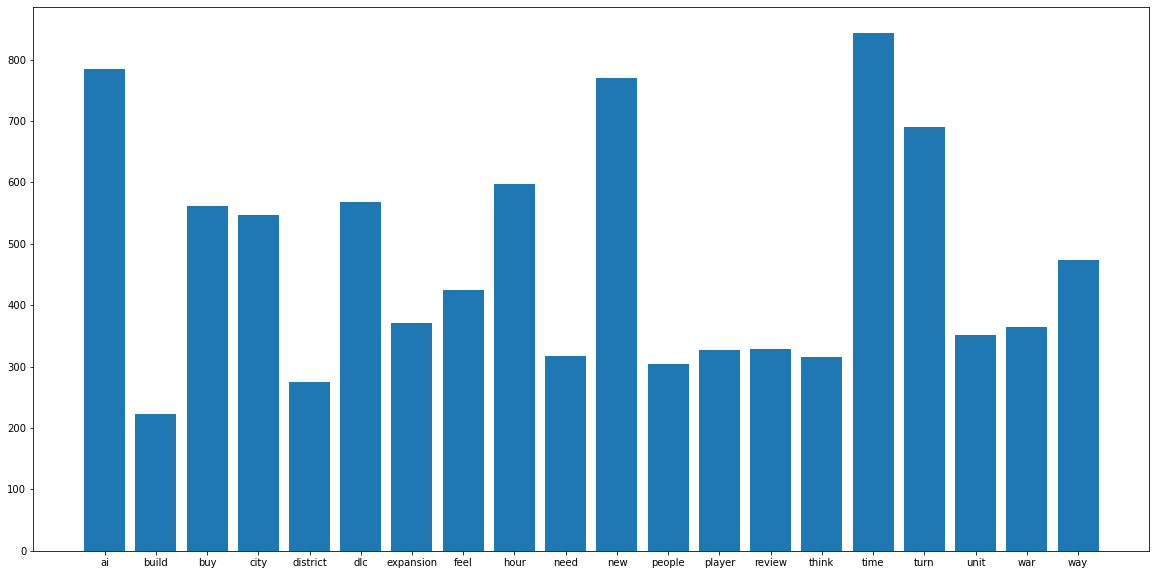

In [44]:
combine = dict(zip(word_list,count_list))
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(range(len(combine)), list(combine.values()), align='center')
ax.set_xticklabels(list(combine.keys()))
ax.set_xticks(range(len(combine)))
plt.show()

# Modeling - Go Each Column

We will test each column and see which one has the best accuracy.

The model we first go with is Naive Bayes classifier

In [46]:
# review no punct
X = df['Review_No_Punct']
y = df['Recommend']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=222)

In [47]:
tvectorizer = TfidfVectorizer(strip_accents='ascii', token_pattern=r'(?u)\b\w\w+\b', stop_words='english')
X_train_tvectorizer = tvectorizer.fit_transform(X_train)
X_test_tvectorizer = tvectorizer.transform(X_test)

In [48]:
# naive bayes
nclf = MultinomialNB()
nclf.fit(X_train_tvectorizer, y_train)
predict = nclf.predict(X_test_tvectorizer)

In [49]:
print(accuracy_score(y_test, predict))
print(precision_score(y_test, predict))
print(recall_score(y_test, predict))

0.8312236286919831
0.8724899598393574
0.7885662431941923


In [50]:
cm = confusion_matrix(y_test, predict)
print(cm)

[[904 127]
 [233 869]]


In [101]:
# Stop_word
X = df['Review_StopWord']
y = df['Recommend']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=222)

In [102]:
tvectorizer = TfidfVectorizer(strip_accents='ascii', token_pattern=r'(?u)\b\w\w+\b', stop_words='english')
X_train_tvectorizer = tvectorizer.fit_transform(X_train)
X_test_tvectorizer = tvectorizer.transform(X_test)

In [103]:
nclf = MultinomialNB()
nclf.fit(X_train_tvectorizer, y_train)
predict = nclf.predict(X_test_tvectorizer)

In [104]:
print(accuracy_score(y_test, predict))
print(precision_score(y_test, predict))
print(recall_score(y_test, predict))

0.8049695264885138
0.855072463768116
0.7495462794918331


In [105]:
cm = confusion_matrix(y_test, predict)
print(cm)

[[891 140]
 [276 826]]


In [56]:
# review stemming
X = df['Review_Stem']
y = df['Recommend']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=222)

In [57]:
tvectorizer = TfidfVectorizer(strip_accents='ascii', token_pattern=r'(?u)\b\w\w+\b', stop_words='english')
X_train_tvectorizer = tvectorizer.fit_transform(X_train)
X_test_tvectorizer = tvectorizer.transform(X_test)

In [58]:
nclf = MultinomialNB()
nclf.fit(X_train_tvectorizer, y_train)
predict = nclf.predict(X_test_tvectorizer)

In [59]:
print(accuracy_score(y_test, predict))
print(precision_score(y_test, predict))
print(recall_score(y_test, predict))

0.8007501172058135
0.8471794871794872
0.7495462794918331


In [60]:
cm = confusion_matrix(y_test, predict)
print(cm)

[[882 149]
 [276 826]]


In [61]:
# review being lemmatized
X = df['Review_Lemma']
y = df['Recommend']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=222)

In [62]:
tvectorizer = TfidfVectorizer(strip_accents='ascii', token_pattern=r'(?u)\b\w\w+\b', stop_words='english')
X_train_tvectorizer = tvectorizer.fit_transform(X_train)
X_test_tvectorizer = tvectorizer.transform(X_test)

In [63]:
nclf = MultinomialNB()
nclf.fit(X_train_tvectorizer, y_train)
predict = nclf.predict(X_test_tvectorizer)

In [64]:
print(accuracy_score(y_test, predict))
print(precision_score(y_test, predict))
print(recall_score(y_test, predict))

0.802625410220347
0.8478038815117467
0.7531760435571688


In [65]:
cm = confusion_matrix(y_test, predict)

In [66]:
print(cm)

[[882 149]
 [272 830]]


# Naive Bayes Classifier Results

It seems that the review without punctuation provides the best results.(83.12%)

However, in order to uncover the true meaning behind the text, we will use the text without stopwords.
By removing stopwords, such as, good, great, bad, we may able to see what other words are being used for both recommend and not recommend side.

By doing that, we may able to uncover the true reason players why they like or dislike this game.

We next will test with a Random Forest Classifier.

In [68]:
# Ranfom Forest

In [69]:
X = df['Review_No_Punct']
y = df['Recommend']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=222)

In [70]:
tvectorizer = TfidfVectorizer(strip_accents='ascii', token_pattern=r'(?u)\b\w\w+\b', stop_words='english')
X_train_tvectorizer = tvectorizer.fit_transform(X_train)
X_test_tvectorizer = tvectorizer.transform(X_test)

In [71]:
rclf = RandomForestClassifier(n_estimators=200, oob_score=True)
rclf.fit(X_train_tvectorizer, y_train)
predict2 = rclf.predict(X_test_tvectorizer)

In [72]:
print(accuracy_score(y_test, predict2))
print(precision_score(y_test, predict2))
print(recall_score(y_test, predict2))

0.8260665729020159
0.8615232443125618
0.7903811252268602


In [73]:
rcm = confusion_matrix(y_test, predict2)
print(rcm)

[[891 140]
 [231 871]]


In [106]:
X = df['Review_StopWord']
y = df['Recommend']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=222)

In [107]:
tvectorizer = TfidfVectorizer(strip_accents='ascii', token_pattern=r'(?u)\b\w\w+\b', stop_words='english')
X_train_tvectorizer = tvectorizer.fit_transform(X_train)
X_test_tvectorizer = tvectorizer.transform(X_test)

In [108]:
rclf = RandomForestClassifier(n_estimators=100, oob_score=True)
rclf.fit(X_train_tvectorizer, y_train)
predict2 = rclf.predict(X_test_tvectorizer)

In [109]:
print(accuracy_score(y_test, predict2))
print(precision_score(y_test, predict2))
print(recall_score(y_test, predict2))

0.7848101265822784
0.8136585365853658
0.7568058076225045


In [110]:
rcm = confusion_matrix(y_test, predict2)
print(rcm)

[[840 191]
 [268 834]]


In [79]:
X = df['Review_Stem']
y = df['Recommend']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=222)

In [80]:
tvectorizer = TfidfVectorizer(strip_accents='ascii', token_pattern=r'(?u)\b\w\w+\b', stop_words='english')
X_train_tvectorizer = tvectorizer.fit_transform(X_train)
X_test_tvectorizer = tvectorizer.transform(X_test)

In [81]:
rclf = RandomForestClassifier(n_estimators=100, oob_score=True)
rclf.fit(X_train_tvectorizer, y_train)
predict2 = rclf.predict(X_test_tvectorizer)

In [82]:
print(accuracy_score(y_test, predict2))
print(precision_score(y_test, predict2))
print(recall_score(y_test, predict2))

0.8016877637130801
0.8378109452736319
0.764065335753176


In [83]:
rcm = confusion_matrix(y_test, predict2)
print(rcm)

[[868 163]
 [260 842]]


In [84]:
X = df['Review_Lemma']
y = df['Recommend']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [85]:
tvectorizer = TfidfVectorizer(strip_accents='ascii', token_pattern=r'(?u)\b\w\w+\b', stop_words='english')
X_train_tvectorizer = tvectorizer.fit_transform(X_train)
X_test_tvectorizer = tvectorizer.transform(X_test)

In [86]:
rclf = RandomForestClassifier(n_estimators=100, oob_score=True)
rclf.fit(X_train_tvectorizer, y_train)
predict2 = rclf.predict(X_test_tvectorizer)

In [87]:
print(accuracy_score(y_test, predict2))
print(precision_score(y_test, predict2))
print(recall_score(y_test, predict2))

0.7951242381622129
0.8239171374764596
0.7777777777777778


In [88]:
rcm = confusion_matrix(y_test, predict2)
print(rcm)

[[821 187]
 [250 875]]


# Random Forest Classifier Results

It seems that the Random Forest classifier also experiencing similar results, which text without punctuation did the best job.

However, Random Forest did a bit poorly compare to Naive Bayes, but we can use the feature importance to see which word is important to us.

We will see the top 10 words using below function!

In [89]:
def tdif_most_important_values_for_random_forest(tdif_vectorizer, fit_random_forest):    
    d= {}
    for imp,word in zip(list(rclf.feature_importances_),tdif_vectorizer.get_feature_names()):
        d[word] = imp
    sorted_values = list(reversed(sorted(d.values()))) # Sort the values
    sorted_dict = {}
    for i in sorted_values:
        for k in d.keys():
            if d[k] == i:
                sorted_dict[k] = d[k]
                break
    return sorted_dict

In [90]:
rf_feature_importance = dict(Counter(tdif_most_important_values_for_random_forest(tvectorizer, rclf)).most_common(10))

In [91]:
rf_feature_importance

{'crash': 0.01394137798655659,
 'spyware': 0.012472112535649975,
 'money': 0.010249969036524668,
 'ai': 0.007956393792937687,
 'mac': 0.007660002492992685,
 'worst': 0.007594828224598949,
 'buy': 0.007211957323487289,
 'boring': 0.0068818288990514205,
 'unplayable': 0.006262673401811366,
 'eula': 0.006215949845781488}

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


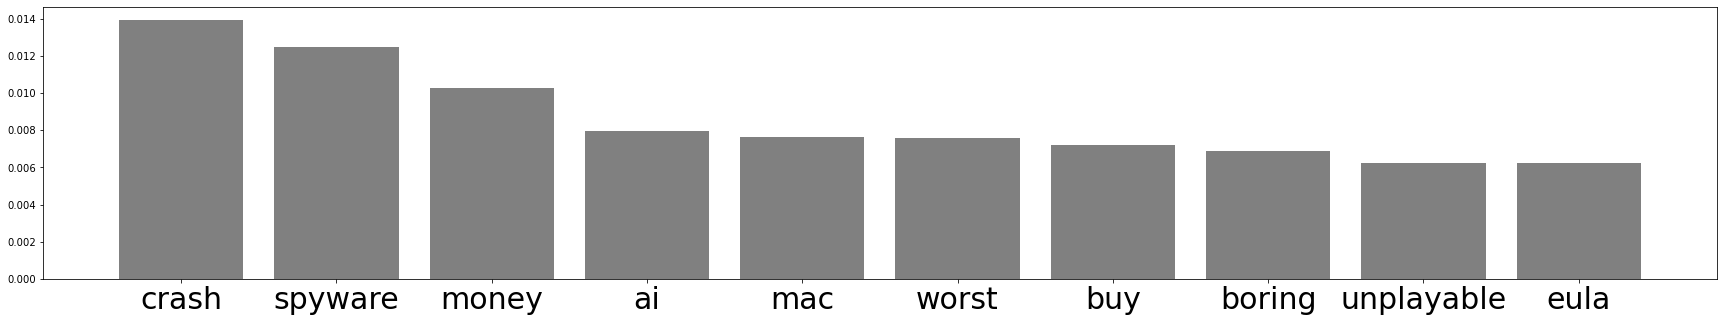

In [93]:
fig, ax = plt.subplots(figsize = (30,5))
ax.bar(range(len(rf_feature_importance)), list(rf_feature_importance.values()), align='center', color='grey')
ax.set_xticklabels(list(rf_feature_importance.keys()), fontsize=30)
ax.set_xticks(range(len(rf_feature_importance)))
plt.show()

# Other Models 
### Logistic Regression, Stochastic Gradient Descent (SGD), Support-Vector Machine (SVM)

We want to test with other models.

Other models, seem to perform similarly.

In [114]:
X = df['Review_StopWord']
y = df['Recommend']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=222)
tvectorizer = TfidfVectorizer(strip_accents='ascii', token_pattern=r'(?u)\b\w\w+\b', stop_words='english')
X_train_tvectorizer = tvectorizer.fit_transform(X_train)
X_test_tvectorizer = tvectorizer.transform(X_test)

# LogReg model
lgr = LogisticRegression(max_iter=2000)
lgr.fit(X_train_tvectorizer, y_train)
predict = lgr.predict(X_test_tvectorizer)

# Results
print(accuracy_score(y_test, predict))
print(precision_score(y_test, predict))
print(recall_score(y_test, predict))
cm = confusion_matrix(y_test, predict)
print(cm)

0.817627754336615
0.7998317914213625
0.8629764065335753
[[793 238]
 [151 951]]


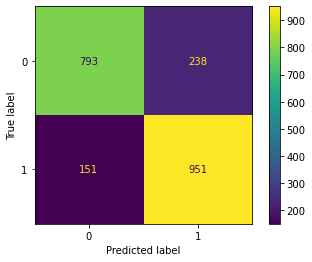

In [95]:
plot_confusion_matrix(lgr, X_test_tvectorizer, y_test);

In [112]:
X = df['Review_StopWord']
y = df['Recommend']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=222)
tvectorizer = TfidfVectorizer(strip_accents='ascii', token_pattern=r'(?u)\b\w\w+\b', stop_words='english')
X_train_tvectorizer = tvectorizer.fit_transform(X_train)
X_test_tvectorizer = tvectorizer.transform(X_test)

# SGD model
sgd = SGDClassifier()
sgd.fit(X_train_tvectorizer, y_train)
predict = sgd.predict(X_test_tvectorizer)


# Results
print(accuracy_score(y_test, predict))
print(precision_score(y_test, predict))
print(recall_score(y_test, predict))
cm = confusion_matrix(y_test, predict)
print(cm)

0.817627754336615
0.798326359832636
0.8656987295825771
[[790 241]
 [148 954]]


In [113]:
X = df['Review_StopWord']
y = df['Recommend']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=222)
tvectorizer = TfidfVectorizer(strip_accents='ascii', token_pattern=r'(?u)\b\w\w+\b', stop_words='english')
X_train_tvectorizer = tvectorizer.fit_transform(X_train)
X_test_tvectorizer = tvectorizer.transform(X_test)

# SVM model
sclf = svm.SVC()
sclf.fit(X_train_tvectorizer, y_train)
predict = sclf.predict(X_test_tvectorizer)

# Results
print(accuracy_score(y_test, predict))
print(precision_score(y_test, predict))
print(recall_score(y_test, predict))
cm = confusion_matrix(y_test, predict)
print(cm)

0.8251289263947492
0.8155844155844156
0.8548094373865699
[[818 213]
 [160 942]]


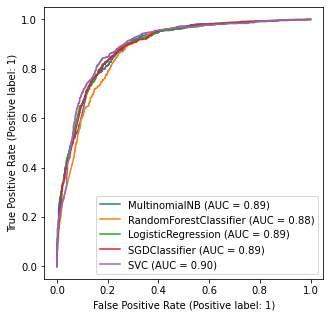

In [121]:
fig, ax = plt.subplots(figsize=(5,5))
ax = plt.gca()

model = [nclf, rclf, lgr, sgd, sclf]
for i in model:
    plot_roc_curve(i, X_test_tvectorizer, y_test, ax=ax)

# Compare Prediction with Actual Data

We want to explore which words are important for both sides, and we want to see which row is being miss-predicted.

In [122]:
testPredict = []
for i in range(len(X_test)):
    if predict[i] == 1:
        testPredict.append('Recommend')
    else:
        testPredict.append('Not Recommend')

In [123]:
check_df = pd.DataFrame({'actual_data': list(y_test), 'prediction': testPredict, 'Review_StopWord':list(X_test)})
check_df.replace(to_replace=0, value='Not Recommend', inplace=True)
check_df.replace(to_replace=1, value='Recommend', inplace=True)

In [124]:
check_df[:20]

actual_data     prediction  \
0   Not Recommend  Not Recommend   
1   Not Recommend      Recommend   
2       Recommend      Recommend   
3       Recommend      Recommend   
4   Not Recommend      Recommend   
5   Not Recommend  Not Recommend   
6   Not Recommend  Not Recommend   
7       Recommend      Recommend   
8       Recommend      Recommend   
9   Not Recommend      Recommend   
10      Recommend      Recommend   
11      Recommend      Recommend   
12  Not Recommend  Not Recommend   
13  Not Recommend  Not Recommend   
14      Recommend      Recommend   
15      Recommend      Recommend   
16  Not Recommend  Not Recommend   
17      Recommend      Recommend   
18  Not Recommend  Not Recommend   
19      Recommend      Recommend   

                                      Review_StopWord  
0                            red shell spyware thanks  
1                             eh alright cant get dlc  
2                                                      
3                                        24 hours day  
4   series liked 4 still 5 6 much crazy unbalanced...  
5   type caused bang desk full single player stupi...  
6   need years worth patches get maybe expantion p...  
7                                yeah boiiiiiiiiiiiii  
8   truly waork art startegy history video rolled ...  
9                                   see al capone 110  
10                                              funny  
11  loved v pick one far enjoying far recommend bu...  
12  ok concern stutters occasionally crashes randomly  
13  hong kong independent country another didnt ch...  
14  though opinion still 5 still different 6 strat...  
15  always favorite mine one fail lots new conside...  
16  used spend days 5 addictive 6 leap back big le...  
17  hard stop flaws multiplayer polishbalance issu...  
18                            five uglier graphics eh  
19    invade oil rich countries without wmd cause 911

In [125]:
check_df['notMatch'] = np.where(check_df['actual_data'] != check_df['prediction'],'Not Match','Match')
x = check_df[check_df['notMatch'] == 'Not Match']

In [126]:
pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = 999
x.iloc[:]

actual_data     prediction  \
1     Not Recommend      Recommend   
4     Not Recommend      Recommend   
9     Not Recommend      Recommend   
20        Recommend  Not Recommend   
27        Recommend  Not Recommend   
30        Recommend  Not Recommend   
42        Recommend  Not Recommend   
49    Not Recommend      Recommend   
55    Not Recommend      Recommend   
65        Recommend  Not Recommend   
67    Not Recommend      Recommend   
75    Not Recommend      Recommend   
77    Not Recommend      Recommend   
80    Not Recommend      Recommend   
84    Not Recommend      Recommend   
89        Recommend  Not Recommend   
111   Not Recommend      Recommend   
113       Recommend  Not Recommend   
121       Recommend  Not Recommend   
123   Not Recommend      Recommend   
124   Not Recommend      Recommend   
132   Not Recommend      Recommend   
135   Not Recommend      Recommend   
148   Not Recommend      Recommend   
149   Not Recommend      Recommend   
150   Not Recommend      Recommend   
154   Not Recommend      Recommend   
156   Not Recommend      Recommend   
157       Recommend  Not Recommend   
161       Recommend  Not Recommend   
167       Recommend  Not Recommend   
171       Recommend  Not Recommend   
177       Recommend  Not Recommend   
182       Recommend  Not Recommend   
185   Not Recommend      Recommend   
194   Not Recommend      Recommend   
196       Recommend  Not Recommend   
202       Recommend  Not Recommend   
204       Recommend  Not Recommend   
212   Not Recommend      Recommend   
214   Not Recommend      Recommend   
217       Recommend  Not Recommend   
218   Not Recommend      Recommend   
237   Not Recommend      Recommend   
238   Not Recommend      Recommend   
239   Not Recommend      Recommend   
255   Not Recommend      Recommend   
276       Recommend  Not Recommend   
277       Recommend  Not Recommend   
284   Not Recommend      Recommend   
289       Recommend  Not Recommend   
292       Recommend  Not Recommend   
296   Not Recommend      Recommend   
301       Recommend  Not Recommend   
302   Not Recommend      Recommend   
321   Not Recommend      Recommend   
325   Not Recommend      Recommend   
330       Recommend  Not Recommend   
343   Not Recommend      Recommend   
344       Recommend  Not Recommend   
349   Not Recommend      Recommend   
355       Recommend  Not Recommend   
357   Not Recommend      Recommend   
358       Recommend  Not Recommend   
366   Not Recommend      Recommend   
370   Not Recommend      Recommend   
377   Not Recommend      Recommend   
379       Recommend  Not Recommend   
381       Recommend  Not Recommend   
384   Not Recommend      Recommend   
389   Not Recommend      Recommend   
390   Not Recommend      Recommend   
391   Not Recommend      Recommend   
393       Recommend  Not Recommend   
395       Recommend  Not Recommend   
405   Not Recommend      Recommend   
406   Not Recommend      Recommend   
407   Not Recommend      Recommend   
410   Not Recommend      Recommend   
416       Recommend  Not Recommend   
420       Recommend  Not Recommend   
429   Not Recommend      Recommend   
439       Recommend  Not Recommend   
452       Recommend  Not Recommend   
467   Not Recommend      Recommend   
471   Not Recommend      Recommend   
475   Not Recommend      Recommend   
480   Not Recommend      Recommend   
495   Not Recommend      Recommend   
497   Not Recommend      Recommend   
505   Not Recommend      Recommend   
512       Recommend  Not Recommend   
520   Not Recommend      Recommend   
522   Not Recommend      Recommend   
532   Not Recommend      Recommend   
534   Not Recommend      Recommend   
544       Recommend  Not Recommend   
556   Not Recommend      Recommend   
557   Not Recommend      Recommend   
563       Recommend  Not Recommend   
568   Not Recommend      Recommend   
581   Not Recommend      Recommend   
585   Not Recommend      Recommend   
586   Not Recommend      Recommend   
589       Recommen

In [127]:
y = check_df[check_df['notMatch'] == 'Match']

In [128]:
y_rcmd = y[y['actual_data'] == 'Recommend']
y_not_rcmd = y[y['actual_data'] == 'Not Recommend']

In [129]:
y_rcmd

actual_data prediction  \
2      Recommend  Recommend   
3      Recommend  Recommend   
7      Recommend  Recommend   
8      Recommend  Recommend   
10     Recommend  Recommend   
11     Recommend  Recommend   
14     Recommend  Recommend   
15     Recommend  Recommend   
17     Recommend  Recommend   
19     Recommend  Recommend   
25     Recommend  Recommend   
28     Recommend  Recommend   
31     Recommend  Recommend   
32     Recommend  Recommend   
35     Recommend  Recommend   
38     Recommend  Recommend   
39     Recommend  Recommend   
40     Recommend  Recommend   
41     Recommend  Recommend   
45     Recommend  Recommend   
46     Recommend  Recommend   
50     Recommend  Recommend   
51     Recommend  Recommend   
52     Recommend  Recommend   
53     Recommend  Recommend   
54     Recommend  Recommend   
56     Recommend  Recommend   
57     Recommend  Recommend   
59     Recommend  Recommend   
60     Recommend  Recommend   
61     Recommend  Recommend   
62     Recommend  Recommend   
69     Recommend  Recommend   
70     Recommend  Recommend   
71     Recommend  Recommend   
73     Recommend  Recommend   
74     Recommend  Recommend   
78     Recommend  Recommend   
81     Recommend  Recommend   
82     Recommend  Recommend   
85     Recommend  Recommend   
90     Recommend  Recommend   
94     Recommend  Recommend   
96     Recommend  Recommend   
97     Recommend  Recommend   
99     Recommend  Recommend   
100    Recommend  Recommend   
101    Recommend  Recommend   
102    Recommend  Recommend   
103    Recommend  Recommend   
106    Recommend  Recommend   
107    Recommend  Recommend   
118    Recommend  Recommend   
119    Recommend  Recommend   
125    Recommend  Recommend   
126    Recommend  Recommend   
127    Recommend  Recommend   
128    Recommend  Recommend   
129    Recommend  Recommend   
130    Recommend  Recommend   
134    Recommend  Recommend   
136    Recommend  Recommend   
137    Recommend  Recommend   
138    Recommend  Recommend   
141    Recommend  Recommend   
142    Recommend  Recommend   
145    Recommend  Recommend   
151    Recommend  Recommend   
152    Recommend  Recommend   
153    Recommend  Recommend   
155    Recommend  Recommend   
158    Recommend  Recommend   
159    Recommend  Recommend   
162    Recommend  Recommend   
165    Recommend  Recommend   
166    Recommend  Recommend   
170    Recommend  Recommend   
174    Recommend  Recommend   
175    Recommend  Recommend   
176    Recommend  Recommend   
178    Recommend  Recommend   
180    Recommend  Recommend   
181    Recommend  Recommend   
184    Recommend  Recommend   
186    Recommend  Recommend   
187    Recommend  Recommend   
191    Recommend  Recommend   
192    Recommend  Recommend   
193    Recommend  Recommend   
198    Recommend  Recommend   
199    Recommend  Recommend   
200    Recommend  Recommend   
201    Recommend  Recommend   
203    Recommend  Recommend   
205    Recommend  Recommend   
206    Recommend  Recommend   
208    Recommend  Recommend   
209    Recommend  Recommend   
222    Recommend  Recommend   
223    Recommend  Recommend   
225    Recommend  Recommend   
228    Recommend  Recommend   
229    Recommend  Recommend   
230    Recommend  Recommend   
232    Recommend  Recommend   
234    Recommend  Recommend   
236    Recommend  Recommend   
241    Recommend  Recommend   
242    Recommend  Recommend   
244    Recommend  Recommend   
245    Recommend  Recommend   
247    Recommend  Recommend   
248    Recommend  Recommend   
249    Recommend  Recommend   
252    Recommend  Recommend   
253    Recommend  Recommend   
257    Recommend  Recommend   
258    Recommend  Recommend   
259    Recommend  Recommend   
260    Recommend  Recommend   
262    Recommend  Recommend   
263    Recommend  Recommend   
264    Recommend  Recommend   
267    Recommend  Recommend   
268    Recommend  Recommend   
269    Recommend  Recommend   
270    Recommend  Recommend   
271    Recommend  Recommend   
272   

In [130]:
vectorizer = TfidfVectorizer(strip_accents='ascii', min_df=5, stop_words='english')
X = vectorizer.fit_transform(y_rcmd['Review_StopWord'])
word_list = vectorizer.get_feature_names()
count_list = X.toarray().sum(axis=0)

In [131]:
rcmd_combine = dict(zip(word_list,count_list))
rtop20 = dict(Counter(rcmd_combine).most_common(20))

In [132]:
rtop20

{'turn': 31.765907445757183,
 'time': 24.81125410286284,
 'hours': 23.160405308021662,
 'new': 22.060609821138065,
 'strategy': 16.10314555866121,
 'series': 14.517609080437971,
 'friends': 13.643661418977315,
 'ai': 12.616462005242182,
 'recommend': 11.756064876713804,
 'addictive': 11.71874377301331,
 'buy': 10.692549131899707,
 'free': 10.250272401645802,
 'city': 9.997583037309754,
 'worth': 9.77733137592416,
 'sale': 9.687721150867727,
 'people': 9.461488782634703,
 'gameplay': 9.324135164045508,
 'think': 9.31492777405004,
 'cities': 9.067839093027859,
 'start': 8.880037791396113}

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


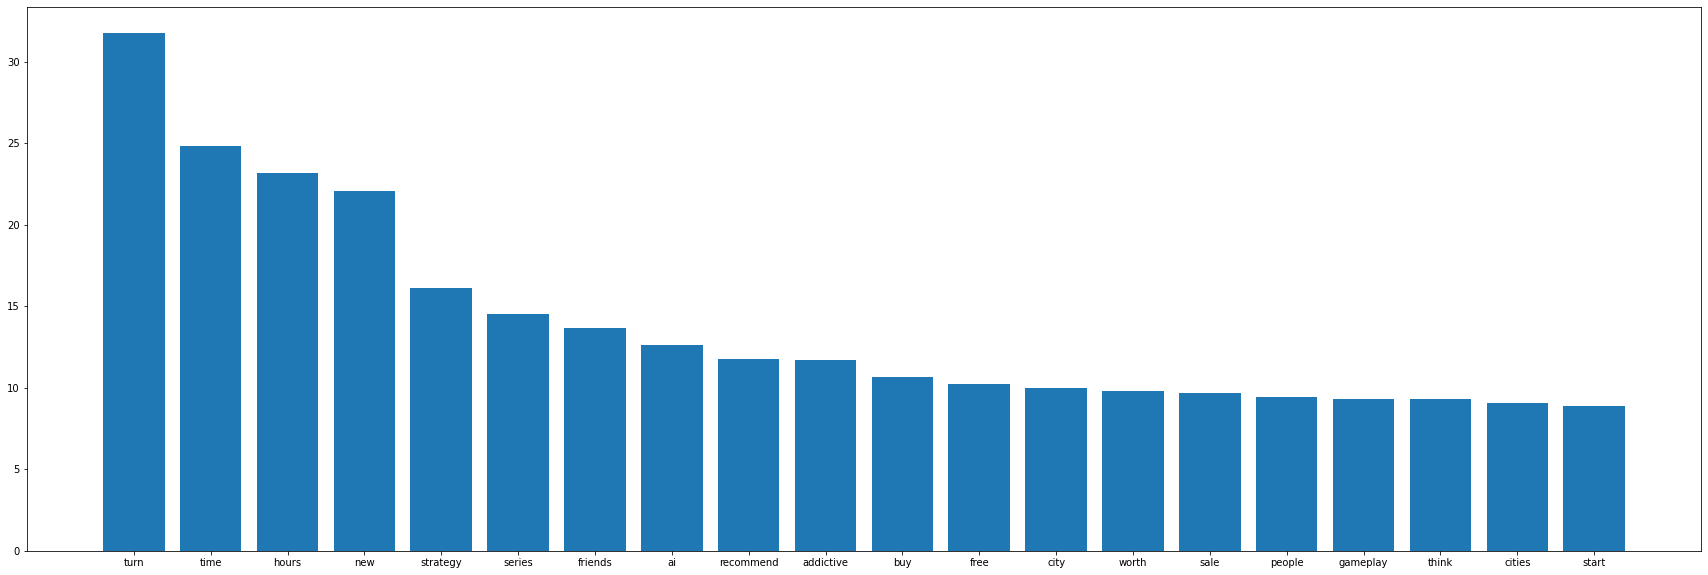

In [133]:
fig, ax = plt.subplots(figsize = (30,10))
ax.bar(range(len(rtop20)), list(rtop20.values()), align='center')
ax.set_xticklabels(list(rtop20.keys()))
ax.set_xticks(range(len(rtop20)))
plt.show()

In [134]:
vectorizer = TfidfVectorizer(strip_accents='ascii', min_df=5, stop_words='english')
X = vectorizer.fit_transform(y_not_rcmd['Review_StopWord'])
word_list = vectorizer.get_feature_names()
count_list = X.toarray().sum(axis=0)

In [135]:
n_rcmd_combine = dict(zip(word_list,count_list))
n_rtop20 = dict(Counter(n_rcmd_combine).most_common(20))

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


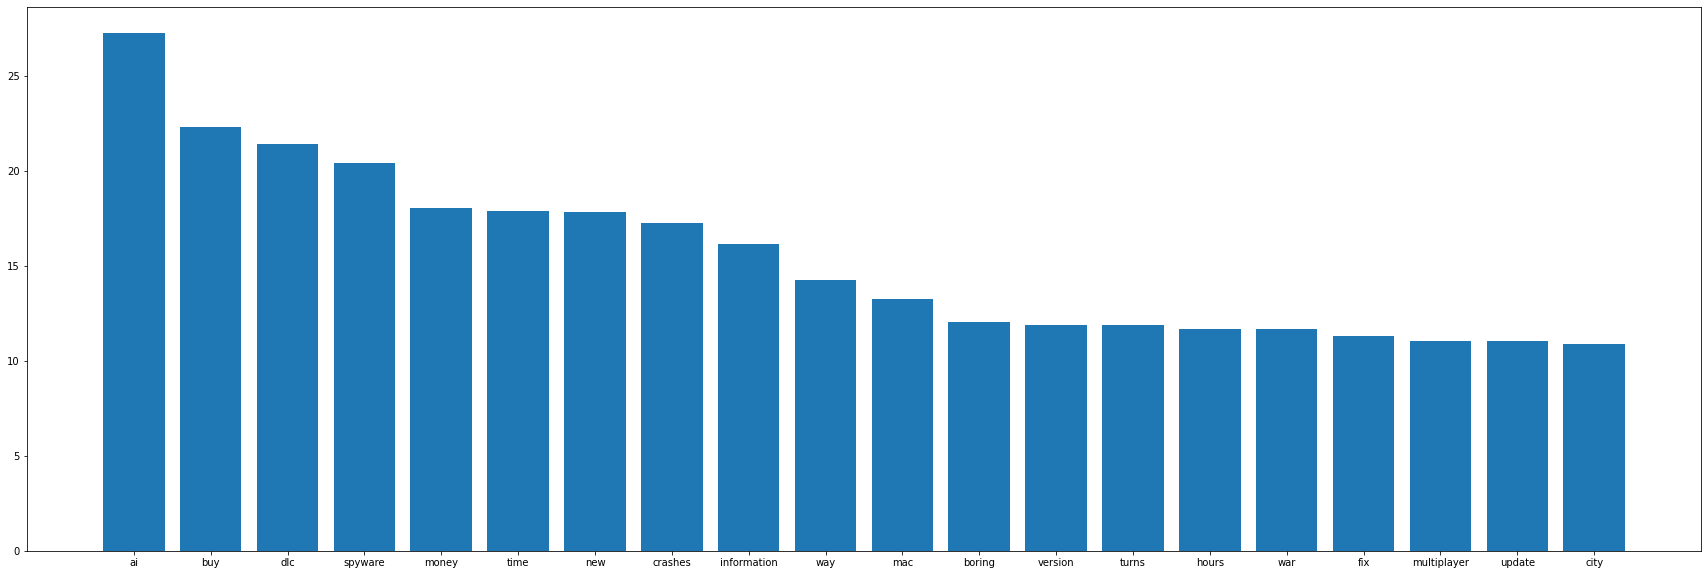

In [136]:
fig, ax = plt.subplots(figsize = (30,10))
ax.bar(range(len(n_rtop20)), list(n_rtop20.values()), align='center')
ax.set_xticklabels(list(n_rtop20.keys()))
ax.set_xticks(range(len(n_rtop20)))
plt.show()

# Compare Between Recommend Side and Not Recommend Side

We want to find the difference and find the true words that represent both sides.

In [138]:
good_words = {key: rcmd_combine[key] - n_rcmd_combine.get(key, 0) for key in rcmd_combine.keys()}
good_after = dict(Counter(good_words).most_common(30))
good_after

{'turn': 21.081380892480595,
 'strategy': 13.42267994612403,
 'addictive': 11.71874377301331,
 'hours': 11.482952131549899,
 'series': 8.682952278304718,
 'friends': 8.494326207524892,
 'ghandi': 7.738534028008723,
 'nuked': 7.308602286732289,
 'time': 6.926777102910929,
 'gandhi': 6.494037649495234,
 'life': 6.035824344671889,
 'gud': 6.0,
 'lots': 5.650799898395158,
 'nukes': 5.644416405034725,
 'nuke': 5.438052514191346,
 'nan': 5.0,
 'funny': 4.9401856067723315,
 'fantastic': 4.764496265590012,
 'addicting': 4.600200172194578,
 'gameplay': 4.572420845992511,
 'received': 4.3333402056972945,
 'new': 4.189604666235066,
 'enjoy': 3.9814903671407142,
 'sleep': 3.95026352292632,
 'yeah': 3.6539557876797097,
 'replayability': 3.6242675378803257,
 'solid': 3.533726563617094,
 'learning': 3.5018628687727658,
 'different': 3.4768677088493787,
 'world': 3.466324795849467}

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


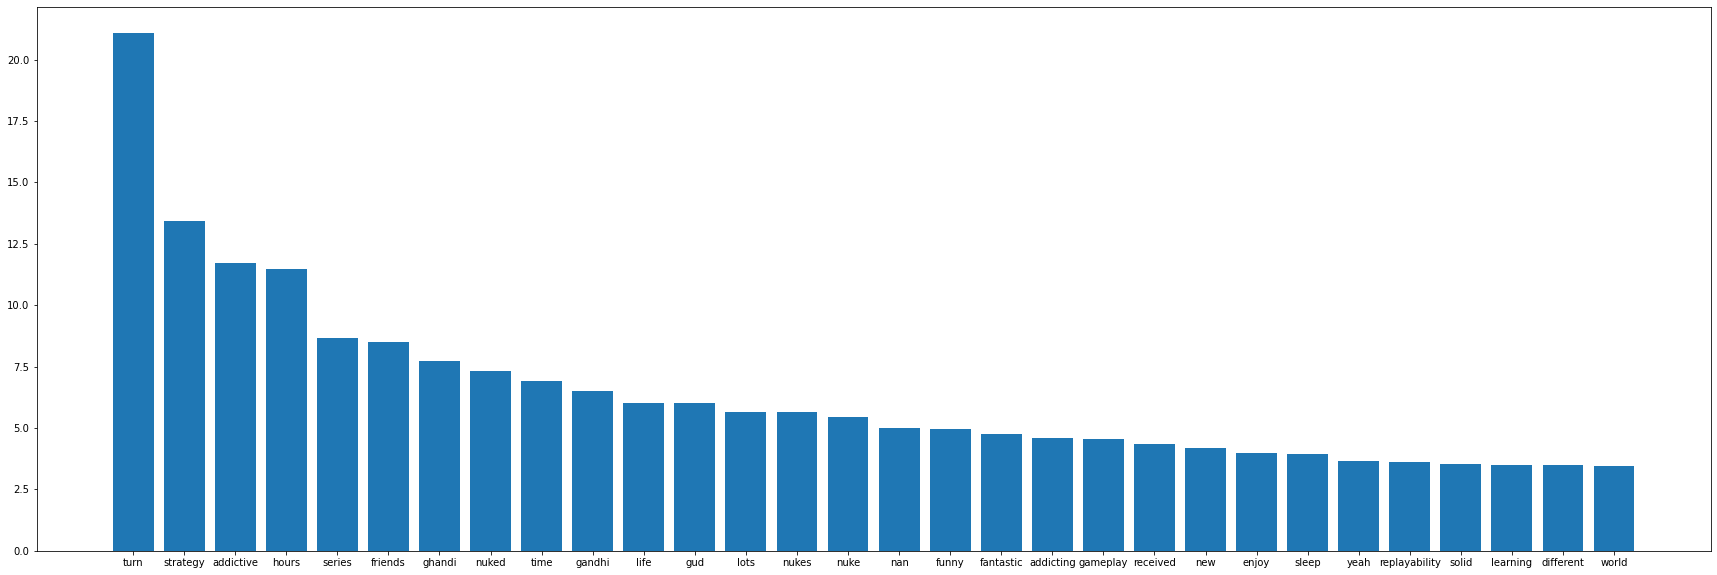

In [139]:
fig, ax = plt.subplots(figsize = (30,10))
ax.bar(range(len(good_after)), list(good_after.values()), align='center')
ax.set_xticklabels(list(good_after.keys()))
ax.set_xticks(range(len(good_after)))
plt.show()

In [140]:
bad_words = {key: n_rcmd_combine[key] - rcmd_combine.get(key, 0) for key in n_rcmd_combine.keys()}
bad_after = dict(Counter(bad_words).most_common(30))
bad_after

{'spyware': 20.411920529770633,
 'crashes': 17.290137575865913,
 'money': 16.42194177500416,
 'information': 16.178693250211396,
 'ai': 14.665329168699822,
 'dlc': 13.637738738058784,
 'mac': 13.274128556747579,
 'boring': 12.082150016859117,
 'buy': 11.614507248137237,
 'eula': 10.529351538981166,
 'fix': 10.211150668171566,
 'update': 9.665032460361305,
 'unplayable': 9.289044033001343,
 'firaxis': 9.252688177318229,
 'version': 8.561417280963738,
 'personal': 8.295409745539965,
 'worst': 8.198993392946935,
 'price': 8.02882771077126,
 'turns': 7.98837821889847,
 'bought': 7.936251479319451,
 'broken': 7.860173340162386,
 'garbage': 7.630999457304051,
 'way': 7.2187143056894305,
 'terrible': 7.181002367871468,
 'address': 6.958427724952807,
 'disappointed': 6.957442855873982,
 'crashing': 6.926815027390692,
 '2k': 6.856328515576922,
 'refund': 6.821861964426076,
 'civ5': 6.7204195326738425}

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


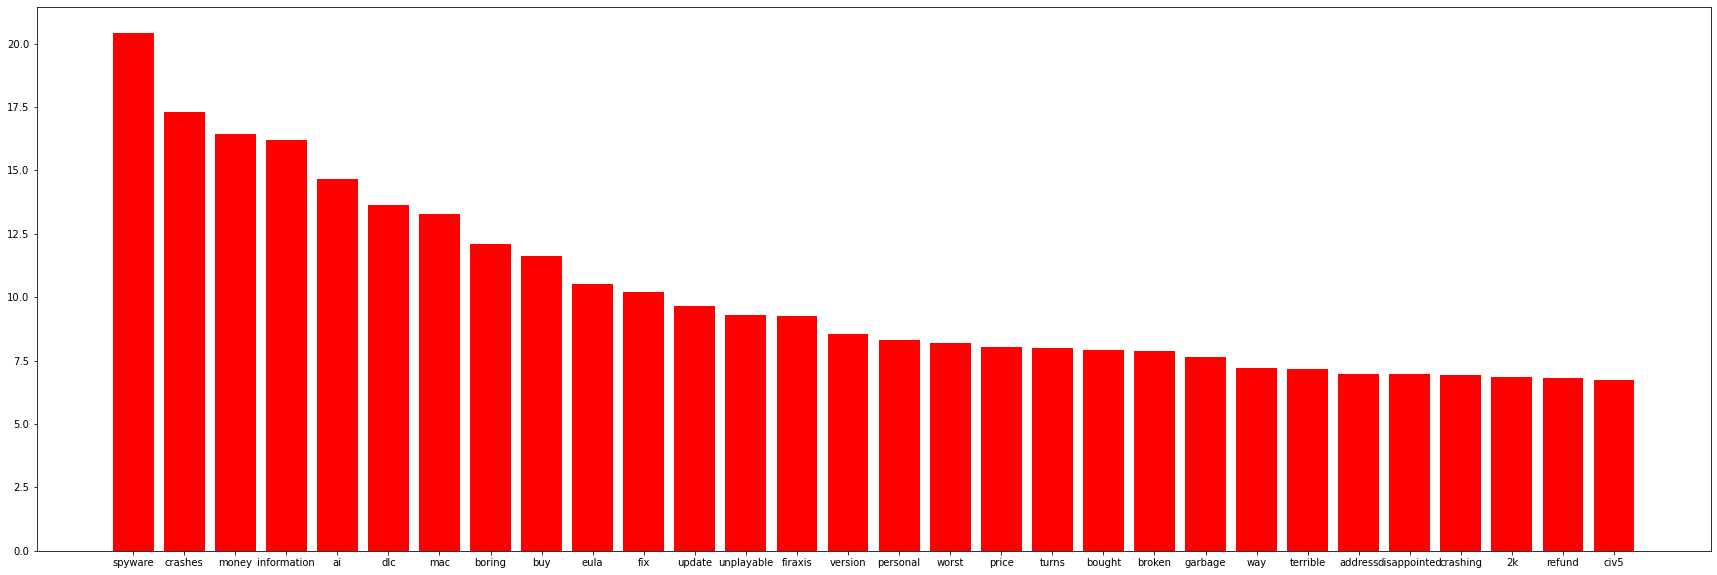

In [141]:
fig, ax = plt.subplots(figsize = (30,10))
ax.bar(range(len(bad_after)), list(bad_after.values()), align='center', color='red')
ax.set_xticklabels(list(bad_after.keys()))
ax.set_xticks(range(len(bad_after)))
plt.show()

# Prediction

In [142]:
#predict
testing = ["civ6 game is the best game ever"]
testing_vec = tvectorizer.transform(testing)

In [143]:
predict = lgr.predict(testing_vec)
proba = lgr.predict_proba(testing_vec)

In [144]:
print(predict)
print(proba)

[1]
[[0.27208119 0.72791881]]


In [145]:
testing = ["I gave up after beaten by the ai"]
testing_vec = tvectorizer.transform(testing)

In [146]:
predict = lgr.predict(testing_vec)
proba = lgr.predict_proba(testing_vec)

In [147]:
print(predict)
print(proba)

[0]
[[0.61365347 0.38634653]]


In [148]:
testing = ["I am interested in strategy game"]
testing_vec = tvectorizer.transform(testing)
predict = lgr.predict(testing_vec)
proba = lgr.predict_proba(testing_vec)
print(predict)
print(proba)

[1]
[[0.08727879 0.91272121]]


In [149]:
testing = ["I want try the game but make sure the ai is not too hard and playable"]
testing_vec = tvectorizer.transform(testing)
predict = lgr.predict(testing_vec)
proba = lgr.predict_proba(testing_vec)
print(predict)
print(proba)

[0]
[[0.54391811 0.45608189]]


In [150]:
testing = ["Is this same as civ5?"]
testing_vec = tvectorizer.transform(testing)
predict = lgr.predict(testing_vec)
proba = lgr.predict_proba(testing_vec)
print(predict)
print(proba)

[0]
[[0.77149901 0.22850099]]
